In [1]:
%matplotlib inline

# Preprocessing and Spike Sorting Tutorial

# Chapter 1: Importing Recording Data and Metadata

In [2]:
import os
import warnings
import glob
import pickle
import _pickle as cPickle
import imp

/tmp/ipykernel_1114749/2492120434.py:6: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [3]:
from collections import defaultdict
import time
import json

In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
import scipy.signal

In [5]:
# Changing the figure size
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

The spikeinterface module by itself import only the spikeinterface.core submodule
which is not useful for end user



In [6]:
import spikeinterface

We need to import one by one different submodules separately (preferred).
There are 5 modules:

- :code:`extractors` : file IO
- :code:`toolkit` : processing toolkit for pre-, post-processing, validation, and automatic curation
- :code:`sorters` : Python wrappers of spike sorters
- :code:`comparison` : comparison of spike sorting output
- :code:`widgets` : visualization



In [7]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

/nancy/user/riwata/projects/spike_gadgets_repo/bin/conda_environment/spike_interface_env/lib/python3.9/site-packages/spikeextractors/extractors/mearecextractors/mearecextractors.py:13: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if StrictVersion(mr.__version__) >= '1.5.0':
/tmp/ipykernel_1114749/634830499.py:3: DeprecationWarning: The 'toolkit' module is deprecated. Use spikeinterface.preprocessing/postptocessing/qualitymetrics instead
  import spikeinterface.toolkit as st


In [8]:
import spikeinterface.core

We can also import all submodules at once with this
  this internally import core+extractors+toolkit+sorters+comparison+widgets+exporters

This is useful for notebooks but this is a more heavy import because internally many more dependency
are imported (scipy/sklearn/networkx/matplotlib/h5py...)



In [9]:
import spikeinterface.full as si

In [10]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (10,6)

# Part 1: Importing Data

## Loading in the Electrophysiology Recording

- Please look at this website to see which importing method matches your data format. https://spikeinterface.readthedocs.io/en/latest/modules/extractors/plot_1_read_various_formats.html#sphx-glr-modules-extractors-plot-1-read-various-formats-py
- You can also try tab completing `se.read_` and see what other electrophysiology data formats are accepted
    - All the different options for importing electrophysiology data:

In [11]:
for method in dir(se):
    if method.startswith("read"):
        print(method)

read_alf_sorting
read_alphaomega
read_alphaomega_event
read_axona
read_bids
read_biocam
read_blackrock
read_blackrock_sorting
read_cbin_ibl
read_ced
read_combinato
read_edf
read_hdsort
read_herdingspikes
read_intan
read_kilosort
read_klusta
read_maxwell
read_maxwell_event
read_mclust
read_mcsh5
read_mcsraw
read_mda_recording
read_mda_sorting
read_mearec
read_neuralynx
read_neuralynx_sorting
read_neuroscope
read_neuroscope_recording
read_neuroscope_sorting
read_nix
read_nwb
read_nwb_recording
read_nwb_sorting
read_openephys
read_openephys_event
read_phy
read_plexon
read_shybrid_recording
read_shybrid_sorting
read_spike2
read_spikegadgets
read_spikeglx
read_spykingcircus
read_tdt
read_tridesclous
read_waveclus
read_waveclus_snippets
read_yass


- Getting a list of all the electrophysiological recording files
    - **NOTE**: If your recording file does not end with `.rec` or is in a different directory than `./data` then you must change `glob.glob({./path/to/recording_file.rec})` below. Where you replace `{./path/to/recording_file.rec}` with the path to your recording file without the brackets.

In [12]:
# Getting all the file paths of the recording files(that happen to all end in `.txt`)
all_recording_files = glob.glob("./data/*.rec/*.rec")

In [13]:
all_recording_files

['./data/20220915_151200_testwithextragrounding.rec/20220915_151200_testwithextragrounding.rec']

- If you have more than one metadata file, then you must either:
    - A. Put the index of the file in `all_meta_data_files[0]` below. You would replace the `0` with the correct index. (Remember, Python is zero indexed so the first file in the list is 0. Second is 1, and so forth.
    - B. Add a absolute or relative path to `open({./path/to/recording_file.rec})` below. You would replace `{./path/to/recording_file.rec}` with the path of the file for the metadata.

- Reading in the data into Spikeinterface
    - **NOTE**: If you are not using Spikegadgets to record your electrophysiological data, then you must change the `read_spikegadgets` below to the format/device that you are using. Look at list above to see which one matches yours.  

In [14]:
recording = se.read_spikegadgets(all_recording_files[0], stream_id="trodes")

In [15]:
type(recording)

spikeinterface.extractors.neoextractors.spikegadgets.SpikeGadgetsRecordingExtractor

## Keeping the channels that were used for the recording 

In [16]:
original_channel_ids = recording.get_channel_ids()


- Removing channel 14 and 15 on Spikeinterface which corresponds to channel 15 and 16 on Spikegadgets. These were used to record the LFPs which won't be part of the spike sorting.

## Metadata from the recording file

This is how you retrieve info from a :code:`RecordingExtractor`...



In [17]:
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()
num_seg = recording.get_num_segments()
duration = recording.get_num_frames()

print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print('Duration:', duration)
print('Number of hours:', duration/fs/3600)

Channel ids: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31']
Sampling frequency: 20000.0
Number of channels: 32
Number of segments: 1
Duration: 21098599
Number of hours: 0.29303609722222224


:code:`spikeinterface` internally uses the :code:`probeinterface`
to handle Probe and ProbeGroup.
 So any probe in the probeinterface collections can be download
and set to a Recording object.
In this case, the MEArec dataset already handles a Probe and we don't need to set it.



...and a :code:`SortingExtractor`



Using the :code:`toolkit`, you can perform preprocessing on the recordings.
Each pre-processing function also returns a :code:`RecordingExtractor`,
which makes it easy to build pipelines. Here, we filter the recording and
apply common median reference (CMR).
All theses preprocessing steps are "lazy". The computation is done on demand when we call
`recording.get_traces(...)` or when we save the object to disk.



# Part 2: Setting Probes

In [18]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_prb, read_prb

- Adding the information about the probes used to record the electrophysiology data.
- If you are using different probes, take a look at:
    - https://probeinterface.readthedocs.io/_/downloads/en/latest/pdf/
    - https://spikeinterface.readthedocs.io/en/latest/modules/core/plot_3_handle_probe_info.html#sphx-glr-modules-core-plot-3-handle-probe-info-py

## Reading in a Probe file

# NOTE: Because not all channels are being used, we will comment out these cells because they assume that the recording has 32 channels

In [19]:
# Getting all the file paths of the recording parameter files(that happen to all end in `.prm`)
all_probe_files = glob.glob("./data/*.prb")

In [20]:
all_probe_files

['./data/nancyprobe_linearprobelargespace.prb']

- If you have more than one metadata file, then you must either:
    - A. Put the index of the file in `all_parameter_files[0]` below. You would replace the `0` with the correct index. (Remember, Python is zero indexed so the first file in the list is 0. Second is 1, and so forth.
    - B. Add a absolute or relative path to `open({./path/to/recording_file.rec})` below. You would replace `{./path/to/recording_file.rec}` with the path of the file for the metadata.

In [21]:
if len(all_probe_files) < 1:
    warnings.warn("There are no parameter files in the directory that you specified. Please add a file, or correct the directory path")
else:
    probe_parameters = imp.load_source("probe_parameters", all_probe_files[0])
    with open(all_probe_files[0]) as info_file:
        lines = info_file.readlines()
        for line in lines:
            print(line)

channel_groups = {0: {'channels': [0,

                  1,

                  2,

                  3,

                  4,

                  5,

                  6,

                  7,

                  8,

                  9,

                  10,

                  11,

                  12,

                  13,

                  14,

                  15,

                  16,

                  17,

                  18,

                  19,

                  20,

                  21,

                  22,

                  23,

                  24,

                  25,

                  26,

                  27,

                  28,

                  29,

                  30,

                  31],

     'geometry':{

    0: (0, 0),

    1: (5, 20),

    2: (-7, 40),

    3: (9, 60),

    4: (-11, 80),

    5: (13, 100),

    6: (-15, 120),

    7: (17, 140),

    8: (-19, 160),

    9: (21, 180),

    10: (-23, 200),

    11: (25, 220),

    12: (-27

- Reading in the probe information into Spike interface and plotting the probe

In [22]:
if len(all_probe_files) < 1:
    warnings.warn("There are no parameter files in the directory that you specified. Please add a file, or correct the directory path")
else:
    # Reading in the probe data
    probe_object = read_prb(all_probe_files[0])

- Creating a dictionary of all the variables in the probe file

In [23]:
if 'probe_parameters' in locals():
    probe_dict = defaultdict(dict)
    for attribute in dir(probe_parameters):
        # Removing built in attributes
        if not attribute.startswith("__"): 
            probe_dict[attribute] = getattr(probe_parameters, attribute)

In [24]:
if "probe_dict" in locals():
    for key, value in probe_dict.items():
        print("{}: {}".format(key, value))

channel_groups: {0: {'channels': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], 'geometry': {0: (0, 0), 1: (5, 20), 2: (-7, 40), 3: (9, 60), 4: (-11, 80), 5: (13, 100), 6: (-15, 120), 7: (17, 140), 8: (-19, 160), 9: (21, 180), 10: (-23, 200), 11: (25, 220), 12: (-27, 240), 13: (29, 260), 14: (-31, 280), 15: (33, 300), 16: (-35, 320), 17: (37, 340), 18: (-39, 360), 19: (41, 380), 20: (-43, 400), 21: (45, 420), 22: (-47, 440), 23: (49, 460), 24: (-51, 480), 25: (53, 500), 26: (-55, 520), 27: (57, 540), 28: (-59, 560), 29: (61, 580), 30: (-63, 600), 31: (65, 620)}, 'graph': [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30), (30, 31)]}}


In [25]:
channel_ids

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31'], dtype='<U64')

In [26]:
channel_ids = np.arange(len(channel_ids))

- Removing channels that aren't going to be used for Spikesorting
- Docstring on set_device_channel_indices function: 

```
    Manually set the device channel indices.

    If some channels are not connected or not recorded then channel should be set to "-1"
```

In [27]:
channel_ids[14]

14

In [ ]:
channel_ids[14] = -1

In [29]:
channel_ids[15]

15

In [ ]:
channel_ids[15] = -1

In [31]:
channel_ids

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, -1, -1, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [32]:
probe_object.set_global_device_channel_indices(channels=channel_ids)

In [44]:
probe_object.get_global_device_channel_indices()

array([(0,  0), (0,  1), (0,  2), (0,  3), (0,  4), (0,  5), (0,  6),
       (0,  7), (0,  8), (0,  9), (0, 10), (0, 11), (0, 12), (0, 13),
       (0, -1), (0, -1), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20),
       (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27),
       (0, 28), (0, 29), (0, 30), (0, 31)],
      dtype=[('probe_index', '<i8'), ('device_channel_indices', '<i8')])

/nancy/user/riwata/projects/spike_gadgets_repo/bin/conda_environment/spike_interface_env/lib/python3.9/site-packages/spikeinterface/core/baserecordingsnippets.py:132: UserWarning: The given probes have unconnected contacts: they are removed
  warn('The given probes have unconnected contacts: they are removed')


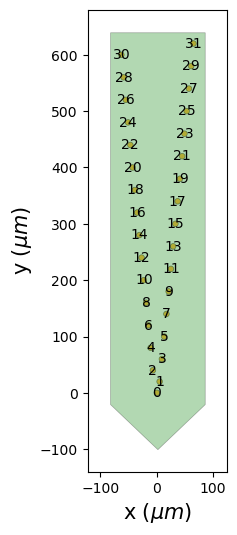

In [33]:

recording = recording.set_probes(probe_object)
# Plotting the probe configuration
plot_probe_group(probe_object, same_axes=False, with_channel_index=True)
plt.show()

## Plotting the electrophysiology activity

:code:`recording` is a :code:`RecordingExtractor` object, which extracts information about channel ids, channel locations
(if present), the sampling frequency of the recording, and the extracellular  traces. :code:`sorting_true` is a
:code:`SortingExtractor` object, which contains information about spike-sorting related information,  including unit ids,
spike trains, etc.
Let's use the :code:`widgets` module to visualize the traces and the raster plots.



- Plotting the activity for all channels for the first 5 seconds
    - Check to see if there's any activity.
    - You can adjust the time by changing `time_range=(0, 5)`. The first number is when the plotting starts in seconds, and the second number is the when the plotting ends.

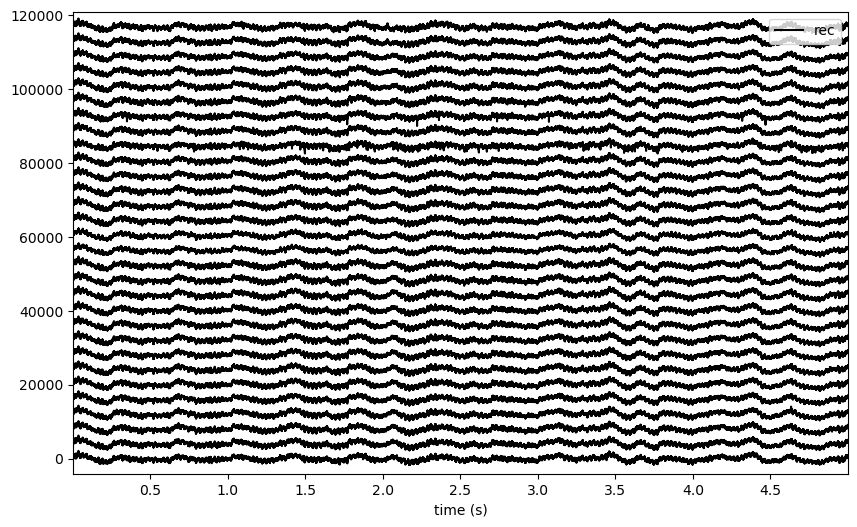

In [34]:
w_ts = sw.plot_timeseries(recording, time_range=(0, 5))


# Saving the Recording Files for the Next Notebook

- Creating an output folder based on the recording file name

In [35]:
recording_file_name = os.path.basename(all_recording_files[0])
recording_file_root = os.path.splitext(recording_file_name)[0]

In [36]:
recording_file_root

'20220915_151200_testwithextragrounding'

In [37]:
parent_output_directory = "./proc/{}".format(recording_file_root)

In [38]:
parent_output_directory

'./proc/20220915_151200_testwithextragrounding'

In [39]:
os.makedirs(parent_output_directory, exist_ok=True)

In [40]:
recording_output_directory = os.path.join(parent_output_directory, "recording_raw")


In [41]:
recording_output_directory

'./proc/20220915_151200_testwithextragrounding/recording_raw'

In [42]:
if not os.path.exists(recording_output_directory):
    recording.save_to_folder(name="recording_raw", folder=recording_output_directory)
else:
    warnings.warn("""Directory already exists for: {}. 
    Either continue on if you are satisfied with the previous run 
    or delete the directory and run this cell again""".format(recording_output_directory))

write_binary_recording with n_jobs = 1 and chunk_size = None


In [46]:
probe_object.get_global_device_channel_indices()

array([(0,  0), (0,  1), (0,  2), (0,  3), (0,  4), (0,  5), (0,  6),
       (0,  7), (0,  8), (0,  9), (0, 10), (0, 11), (0, 12), (0, 13),
       (0, -1), (0, -1), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20),
       (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27),
       (0, 28), (0, 29), (0, 30), (0, 31)],
      dtype=[('probe_index', '<i8'), ('device_channel_indices', '<i8')])